# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 

dirpath = "/kaggle/input/kaggle-survey-2019/"
multiple = pd.read_csv(os.path.join(dirpath, 'multiple_choice_responses.csv'), dtype="object")
other = pd.read_csv(os.path.join(dirpath, 'other_text_responses.csv'))
schema = pd.read_csv(os.path.join(dirpath, 'survey_schema.csv'))
questions = pd.read_csv(os.path.join(dirpath, 'questions_only.csv'))

# do not execute if want to generate the files
multiple.drop(index=0, inplace=True)

import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
from matplotlib import cm
import itertools
from matplotlib.patches import Rectangle, Polygon
from textwrap import wrap
import re

plt.style.use('default')


kaggle_color = '#20beff'

# span style="background:#66c2a5; font-weight:bold; color:white"

def generate_wraptxt(txt, linewidth=40): 
    tit = wrap(txt, width=linewidth)
    return '\n'.join(tit)

def list_colors(cmap_name, n):
    return [plt.cm.get_cmap(cmap_name,n)(x) for x in range(n)]

def create_pivot_for_heatmap(multiple_queried, vertcol="Q15_clean", horzcol="Q23_clean_merged"):

    age_gb = multiple_queried.groupby(['Q1', vertcol, horzcol])['Q2'].count()
    age_gb = pd.DataFrame(age_gb)

    allindices = list(itertools.product(multiple['Q1'].unique().tolist(), 
                                        multiple[vertcol].unique().tolist(),
                                        multiple[horzcol].unique().tolist()))
    missingindices = list(set(allindices)-set(age_gb.index))
    midx = pd.MultiIndex.from_tuples(missingindices, names=age_gb.index.names )
    age_gb2 = pd.concat([age_gb, pd.DataFrame(index=midx, columns=age_gb.columns).fillna(0)], axis=0)
    age_gb2 = age_gb2.sort_index()
    age_gb2 = age_gb2.reset_index()

    allage_codepivot = age_gb2.pivot_table(index=vertcol, columns=horzcol, values="Q2", aggfunc="sum")
    allage_codepivot = allage_codepivot.drop(index='00-00')
    allage_codepivot = allage_codepivot[np.sort(allage_codepivot.columns)]
    return allage_codepivot

def calc_df_hist(df):
    return df/df.sum().sum()

heatmap_args = dict(annot=True, fmt="d", square=False, cmap=cm.get_cmap("Greys",12), 
               center = 90, vmin=0, vmax=500, lw=4, 
               cbar=False)


heatmap_args_nolim = dict(annot=True, fmt="d", square=False, cmap=cm.get_cmap("Greys"), 
               lw=4, 
               cbar=False)

def draw_code_ml_heatmap_general(df,tmp_ax,**kwargs):
    hm = sns.heatmap(df, ax = tmp_ax, 
                **kwargs)
    tmp_ax.set_xlabel('years of using ML methods')
    tmp_ax.set_ylabel('years of coding for data')
    tmp_ax.set_yticklabels(tmp_ax.get_yticklabels(), rotation=0);
    return hm 
    
def draw_code_ml_heatmap(tmp_ax):
    hm = draw_code_ml_heatmap_general(allage_codepivot2, tmp_ax, **heatmap_args)
    return hm

def black_border_around_text(annotation_handle):
    annotation_handle.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
    return annotation_handle

def box_with_annot(x,y,w,h,txt,color,ax):  
    p1 = ax.add_patch(Rectangle((x, y), 
                            w, 
                            h,
                            fill=True, alpha=0.4, color=color, lw=5))
    an1 = ax.annotate(txt, xy=(x+w/2, y+h/2), fontsize=20, color="white", weight='bold',
               verticalalignment='center', horizontalalignment='center')
    return [p1, an1]

def annot_with_arrow(annotxt, annocolor, this_ax, xy_text, xy_start, xy_end, conn_style="arc3,rad=0.2"): 
#     annotxt = "{0:.0f}% of\nKagglers"\
#     .format(np.round(allage_codepivot2.iloc[0:3,0:3].sum().sum()/all_participants, 2)*100)
       
    an2 = this_ax.annotate(annotxt, xy=xy_text, fontsize=16, color=annocolor, weight='bold',
               verticalalignment='center', horizontalalignment='center', annotation_clip=False)
    black_border_around_text(an2);
    arrow = this_ax.annotate('', xy=xy_end,  xycoords='data',
            xytext=xy_start, 
            arrowprops=dict(facecolor=annocolor, shrink=0.05,connectionstyle=conn_style),
            horizontalalignment='right', verticalalignment='top',annotation_clip=False
            )
    return [an2, arrow]

def draw_border_around_axes(this_ax, color="black"):
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color(color)

def draw_mini_heatmap(df, this_ax, titletxt, linewidth=25, **kwargs):
    hm = draw_code_ml_heatmap_general(df, this_ax, **kwargs)
    this_ax.set_title(generate_wraptxt(titletxt, linewidth));
    this_ax.set_frame_on(True)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    this_ax.set_xlabel('')
    this_ax.set_ylabel('')
    draw_border_around_axes(this_ax)
    return hm 

def get_subplotsax_index_from_iterator(i, nc, nr, ax):
    if any([nc==1,nr==1]):
        this_ax = ax[i]
    else:
        rowno = i // nc 
        colno = i % nc 
        this_ax = ax[rowno, colno]
    return this_ax

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def get_unique_vals_naive(col):
    return pd.Series(multiple[col].unique()).dropna().sort_values().values

def get_unique_vals_sorted(col, **sort_kwargs):
    values_list = pd.DataFrame(multiple[col].unique()).dropna()
    chars = ',><$'
    def declutter(x):
        v = x
        for y in chars:
            v = v.replace(y,'')
        return v
    values_list['seq1'] = values_list[0].apply(lambda x: declutter(x).strip())
    values_list['seq'] = values_list['seq1'].apply(lambda x: float(re.split('\D+',x)[0]))
    values_list = values_list.sort_values(by="seq", **sort_kwargs)
#     print(values_list)
    return values_list[0].values

def draw_bare_barplot(col,values_list,this_ax):
    bp = multiple.groupby(col)['Q1'].count()
    bp.reindex(values_list).plot.bar(ax=this_ax, color=kaggle_color, edgecolor='k', lw=0.5)
    xtl = [x.get_text() for x in this_ax.get_xticklabels()]
    xtl = [re.sub(r'\([^)]*\)', '', x).strip() for x in xtl]
    this_ax.set_xticklabels([generate_wraptxt(tit,10) for tit in xtl], fontdict={"fontsize":7});
    this_ax.set_xlabel('')
    this_ax.set_title('# answers')
    pos = this_ax.get_position()
    this_ax.set_position([pos.x0, pos.y0+pos.height/2.75, pos.width, pos.height/2.0])

def draw_bare_barplot_multi(values_list, col_entry_mapping, this_ax):
    
    bp_l = []
    for val in values_list:
        bp_l.append((col_entry_mapping[val],multiple[multiple[val].notnull()].shape[0]))
    bp = pd.DataFrame(bp_l).set_index([0])
    bp.plot.bar(ax=this_ax, color=kaggle_color, edgecolor='k', lw=0.5)
    xtl = [x.get_text() for x in this_ax.get_xticklabels()]
    xtl = [re.sub(r'\([^)]*\)', '', x).strip() for x in xtl]
    this_ax.set_xticklabels([generate_wraptxt(tit,10) for tit in xtl], fontdict={"fontsize":7});
    this_ax.set_xlabel('')
    this_ax.set_title('# answers')
    pos = this_ax.get_position()
    this_ax.set_position([pos.x0, pos.y0+pos.height/2.75, pos.width, pos.height/2.0])
    this_ax.get_legend().remove()

def get_unique_vals_multi(col):
    values_list1 = [x for x in multiple.columns if x.startswith(col+'_Part')]

    col_entry_mapping = dict()
    for c in values_list1:
        col_entry_mapping[c] = multiple[c].dropna().unique()[0]

    values_list = pd.Series(col_entry_mapping, index=col_entry_mapping.keys()).sort_values().axes[0]
    
    return [values_list, col_entry_mapping]

In [2]:
codelength_dict = {
    "1-2 years": "01-02",
"I have never written code":"00-00", 
"nan": "nan", 
"< 1 years":'00-01',
"20+ years":'20-99',
"3-5 years":'03-05',
"5-10 years":'05-10',
"10-20 years":'10-20'   
}

codelength_dict_q23 = {
"1-2 years":'01-02',
"nan":"nan",
"2-3 years":"02-03",
"< 1 years":"00-01",
"10-15 years":"10-15",
"3-4 years":'03-04',
"4-5 years":"04-05",
"5-10 years":"05-10",
"20+ years":"20-99" 
}

multiple['Q15_clean'] = multiple['Q15'].replace(codelength_dict)

multiple['Q23_clean'] = multiple['Q23'].replace(codelength_dict_q23)

codelength_mid_dict = {
    "01-02": 2,
"00-00":-0.5, 
"nan": "nan", 
'00-01': 0.5,
'20-99': 25,
'03-05':4,
'05-10':7.5,
'10-20':15,
}

multiple['Q15_clean_mid'] = multiple['Q15_clean'].replace(codelength_mid_dict)


q23_clean_dict = {
    '03-04':'03-05',
    '04-05':'03-05',
    '02-03':'01-02'
}
multiple['Q23_clean_merged'] = multiple['Q23_clean'].replace(q23_clean_dict)

q15_bars = multiple.groupby('Q15_clean_mid')['Q1'].count()

langs_big = ['Python', 'R', 'SQL']

langs_replacement = {}

for x in get_unique_vals_naive('Q19'):
    if x not in langs_big:
        langs_replacement[x]="Other"
    else:
        langs_replacement[x]=x

multiple['Q19_clean'] = multiple['Q19'].replace(langs_replacement)

seq = {'Q15': pd.Series(codelength_dict).dropna().sort_values().axes[0][:-1], 
      'Q23': pd.Series(codelength_dict_q23).dropna().sort_values().axes[0][:-1]}

allage_codepivot2 = create_pivot_for_heatmap(multiple, "Q15_clean", "Q23_clean_merged")

all_participants = allage_codepivot2.sum().sum()

sorted_keys_q15 = allage_codepivot2.index.tolist()
sorted_keys_q23 = allage_codepivot2.columns.tolist()

ml_first_list = []
for i in range(len(sorted_keys_q15)-1):
    q23_tmp = sorted_keys_q23[i+1:]
    q15_tmp = sorted_keys_q15[i:i+1]
#     print(q23_tmp, q15_tmp)
    tmp_df = multiple[multiple['Q23_clean_merged'].isin(q23_tmp) & multiple['Q15_clean'].isin(q15_tmp)]
#     print(tmp_df.shape)
    ml_first_list.append(tmp_df)

ml_first = pd.concat(ml_first_list)

code_first_list = []
for i in range(len(sorted_keys_q15)-1):
#     print(sorted_keys_q15[i+1:], sorted_keys_q23[i:i+1])
    code_first_list.append(multiple[multiple['Q23_clean_merged'].isin(sorted_keys_q23[i:i+1]) & multiple['Q15_clean'].isin(sorted_keys_q15[i+1:])]) 

code_first = pd.concat(code_first_list)

interrelated_list = []
for i in range(len(sorted_keys_q15)):
    interrelated_list.append(multiple[multiple['Q23_clean_merged'].isin(sorted_keys_q23[i:i+1]) & multiple['Q15_clean'].isin(sorted_keys_q15[i:i+1])]) 

interrelated = pd.concat(interrelated_list)

refhist = calc_df_hist(allage_codepivot2)

multiple_nostudents = multiple.query('Q5 != "Student"')

refhist_nostudents = calc_df_hist(create_pivot_for_heatmap(multiple_nostudents))

refhist_nostudents_nounempl = calc_df_hist(create_pivot_for_heatmap(multiple_nostudents.query('Q5 != "Not employed"')))

zerohist = pd.DataFrame(np.zeros_like(refhist), index=refhist.index, columns=refhist.columns)

In [3]:
def draw_zero_heatmap_legend(this_ax, cbar_ax, df = zerohist):
    cbar_kws = dict(orientation="horizontal", ticks=np.arange(-0.06,0.06,0.01))    
    cbar_pos = cbar_ax.get_position()
    cbar_ax.set_position([cbar_pos.x0, cbar_pos.y0+cbar_pos.height/2, cbar_pos.width, cbar_pos.height/6])

#     cbar_kws = dict(orientation="vertical")
#     cbar_pos = cbar_ax.get_position()
#     cbar_ax.set_position([cbar_pos.x0+cbar_pos.width/2, cbar_pos.y0, cbar_pos.width/4, cbar_pos.height])

    zero_kws = heatmap_args_nolim_sq.copy()
    zero_kws['cbar_ax'] = cbar_ax
    zero_kws['cbar_kws'] = cbar_kws
    zero_kws['cbar'] = True
    
    hm = draw_mini_heatmap(
            df, 
            this_ax, "", **zero_kws)
    arrow_y = this_ax.annotate('', xy=(-0.5,5.5),  xycoords='data',
                xytext=(-0.5,0.5), 
                arrowprops=dict(arrowstyle="->"),
                horizontalalignment='right', verticalalignment='top',annotation_clip=False
                )
    this_ax.set_ylabel('more coding\nexperience',labelpad=15)

    arrow_x = this_ax.annotate('', xy=(5.5,-0.5),  xycoords='data',
                xytext=(0.5,-0.5), 
                arrowprops=dict(arrowstyle="->"),
                horizontalalignment='right', verticalalignment='top',annotation_clip=False
                )
    this_ax.set_xlabel('more ML\nexperience',labelpad=15)
    this_ax.xaxis.set_label_position('top')
    
#     cbar_ax.set_xticks(np.arange(-0.6,0.6,0.1))
    labels = cbar_ax.get_xticks()*100
    cbar_ax.set_xticklabels(["{0:.0f}%".format(x) for x in labels])
    cbar_ax.set_title('histogram difference (perc.points)')
    return hm 

In [4]:
heatmap_args_ref = heatmap_args_nolim.copy()
heatmap_args_ref['square']=True
heatmap_args_ref['annot']=True
heatmap_args_ref['fmt']='.0f'
heatmap_args_ref['cmap']=cm.get_cmap('binary')
heatmap_args_ref['center']=13
heatmap_args_ref['vmax']=25
heatmap_args_ref['vmin']=0
heatmap_args_ref['annot_kws']={"size":7}

heatmap_args_nolim_sq = heatmap_args_nolim.copy()
heatmap_args_nolim_sq['square']=True
heatmap_args_nolim_sq['annot']=False
heatmap_args_nolim_sq['fmt']='.1%'
heatmap_args_nolim_sq['cmap']=cm.get_cmap('seismic_r',11)
heatmap_args_nolim_sq['center']=0
heatmap_args_nolim_sq['vmax']=0.055
heatmap_args_nolim_sq['vmin']=-0.055

In [5]:
def dashboard_single_choice(col, values_list, rh):
    # col = "Q5"
    # values_list = get_unique_vals_naive(col)
    # rh = refhist

    nc = 6 
    nr = int(np.ceil(len(values_list)/nc))+1
    ims = 3

    f, ax_all = plt.subplots(ncols = nc, nrows = nr, figsize = (ims*nc,ims*nr), 
                         gridspec_kw={"wspace":0.75, "hspace":0.25})

    ax = ax_all[1:,:]

    ## ---- draw legend 
    this_ax = get_subplotsax_index_from_iterator(0, nc, nr, ax_all)
    cbar_ax = get_subplotsax_index_from_iterator(1, nc, nr, ax_all)
    gs = cbar_ax.get_gridspec()
    cbar_ax = f.add_subplot(gs[0, 1:3])

    draw_zero_heatmap_legend(this_ax, cbar_ax)

    ## ---- draw reference histogram 
    this_ax = get_subplotsax_index_from_iterator(3, nc, nr, ax_all)
    draw_mini_heatmap(
            round((rh)*100), 
            this_ax, "reference histogram (%)", **heatmap_args_ref)

    ## ---- draw reference bar plot 
    bp_ax = f.add_subplot(gs[0, 4:6])
    draw_bare_barplot(col, values_list, bp_ax);

    ## ---- draw mini heatmaps 
    for i,val in enumerate(values_list):
        this_ax = get_subplotsax_index_from_iterator(i, nc, nr, ax)
        st = create_pivot_for_heatmap(multiple[multiple[col]==val])
        draw_mini_heatmap(
            (calc_df_hist(st) - rh), 
            this_ax, val, **heatmap_args_nolim_sq)


    ## ---- hide axes 
    for a in ax_all[0,1:3]:
        hide_axes(a)
    for a in ax_all[0,4:]:
        hide_axes(a)
    for i in np.arange(len(values_list),ax.shape[0]*ax.shape[1]):
        this_ax = get_subplotsax_index_from_iterator(i, nc, nr, ax)
        hide_axes(this_ax)

    ## ---- suptitle     
    if col.endswith('_clean'):
        col = col.strip('_clean')
    plt.suptitle(col+": "+questions[col].values[0], fontsize=16);

# For the multiple-choice questions 
def dashboard_multi_choice(col, rh):

    values_list, col_entry_mapping = get_unique_vals_multi(col)

    # divider = 2
    # nc = int(np.ceil(len(values_list)/divider))
    # # nc = len(values_list)
    # nr = divider+1

    nc = 6 
    nr = int(np.ceil(len(values_list)/nc))+1
    ims = 3

    f, ax_all = plt.subplots(ncols = nc, nrows = nr, figsize = (ims*nc,ims*nr), 
                         gridspec_kw={"wspace":0.75, "hspace":0.25})

    ax = ax_all[1:,:]

    ## ---- draw legend 
    this_ax = get_subplotsax_index_from_iterator(0, nc, nr, ax_all)
    cbar_ax = get_subplotsax_index_from_iterator(1, nc, nr, ax_all)
    gs = cbar_ax.get_gridspec()
    cbar_ax = f.add_subplot(gs[0, 1:3])

    draw_zero_heatmap_legend(this_ax, cbar_ax)

    ## ---- draw reference histogram 
    this_ax = get_subplotsax_index_from_iterator(3, nc, nr, ax_all)
    draw_mini_heatmap(
            round((rh)*100), 
            this_ax, "reference histogram (%)", **heatmap_args_ref)

    ## ---- draw reference bar plot 
    bp_ax = f.add_subplot(gs[0, 4:6])
    draw_bare_barplot_multi(values_list, col_entry_mapping, bp_ax);

    ## ---- draw mini heatmaps 
    for i,val in enumerate(values_list):
        this_ax = get_subplotsax_index_from_iterator(i, nc, nr, ax)
        st = create_pivot_for_heatmap(multiple[multiple[val].notnull()])
        draw_mini_heatmap(
            (calc_df_hist(st) - rh), 
            this_ax, col_entry_mapping[val], **heatmap_args_nolim_sq)


    ## ---- hide axes 
    for a in ax_all[0,1:3]:
        hide_axes(a)
    for a in ax_all[0,4:]:
        hide_axes(a)
    for i in np.arange(len(values_list),ax.shape[0]*ax.shape[1]):
        this_ax = get_subplotsax_index_from_iterator(i, nc, nr, ax)
        hide_axes(this_ax)

    ## ---- suptitle     
    plt.suptitle(col+": "+questions[col].values[0], fontsize=16);

___

# Who codes what and how long - a story told through a heatmap

This is not a story of a group of people. It is a story of one heatmap. I must confess: bar plots are great, but I just don't like them so much. What I really like is heatmaps - so a heatmap will be the hero of my story. 

But of course, the heatmap will serve as an anchor point to generate insights about the people. The real heroes are always the people. 

Let's begin!

## Chapter 1: the heatmap comes to life

I was inspired by the following two questions from the survey: 
Q15- `How long have you been writing code to analyze data (at work or at school)?`
Q23- `For how many years have you used machine learning methods?`

At first I found it confusing: are these two aspects not the same? But it turns out, they are not! "Writing code to analyze data" does not necessary equal to "using machine learning methods". And the relation between the two can bring some interesting insights about the population of Kagglers. 

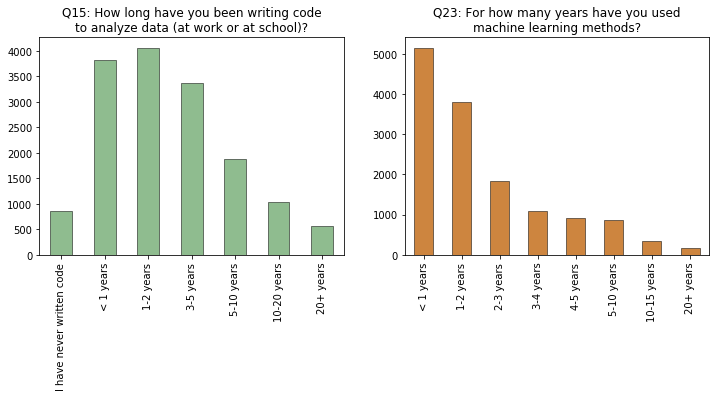

In [6]:
f,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharex=False)

barcolors = ['darkseagreen', 'peru']

barstyle = {"edgecolor":"black", "linewidth":0.5}


for i, col in enumerate(['Q15', 'Q23']):
    this_ax = ax[i]
    multiple.groupby(col)['Q1'].count().reindex(seq[col])\
        .plot.bar(color=barcolors[i], ax=this_ax, **barstyle)
    this_ax.set_title(generate_wraptxt(col+": "+questions[col].values[0], 40))


# allage_codepivot2.loc['20-99'].plot.bar(color=vec_colors[-1], ax=ax[1])

They are clearly not the same, but one problem with them is the bins used. Unfortunately, the responses for Q15 and Q23 have not been made equal - Q23 has more granular bins (`'00-01', '01-02', '02-03', '03-04', '04-05', '05-10', '10-15', '20-99'`) than Q15 (`'00-01', '01-02', '03-05', '05-10', '10-20', '20-99'`). To make them more easily comparable, I aggregate the answers to the Q23 so that they correspond 1:1 with the answers to Q15. To do this, I create a new category, `'03-05'` by summing up the categories `'03-04'`, `'04-05'`, and I add the entries from category `'02-03'` to `'01-02'`. It is an arbitrary choice in case of the category `'02-03'`. 

I am not interested in comparing the two bar plots however. I would like to know how the two questions interrelate. So let's create a pivot table and plot the answers to these survey questions against each other as a heatmap, with insights from Q23 plotted horizontally and from Q15 - vertically. For the sake of comparison, on the sides I draw again the two bar-plots, representing the aggregated values across each dimension. Therefore, the vertical bar plot on the left is a <span style="background:darkseagreen; font-weight:bold; color:white">histogram of answers to the Q15</span>, while the horizontal bar plot on the top represents summary of <span style="background:peru; font-weight:bold; color:white">answers to the Q23</span>, with the aggregated bins. Comparing these two bar plots, we can see that the two are not symmetric - there is more experienced coders than experienced ML-practitioners. 

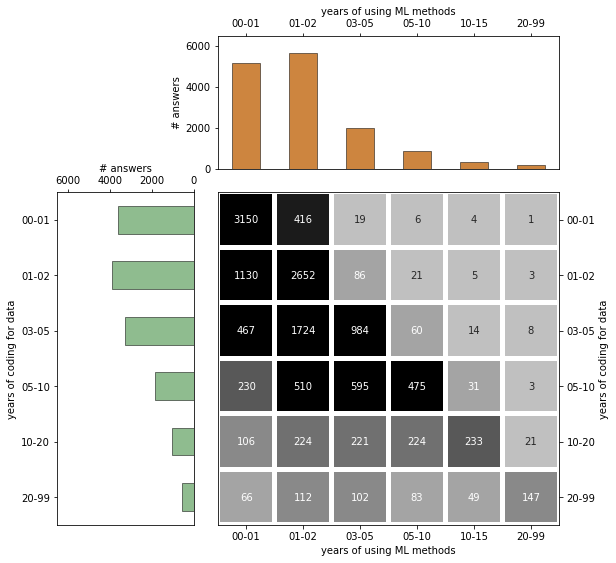

In [7]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

this_ax = ax[0,0]
hide_axes(this_ax)

hm_ax = ax[1,1]
draw_code_ml_heatmap(hm_ax);
hm_ax.yaxis.tick_right()
hm_ax.yaxis.set_label_position("right")
draw_border_around_axes(hm_ax)

# barstyle = {"edgecolor":"black", "linewidth":0.5}

this_ax = ax[0,1]
allage_codepivot2.sum(axis=0).plot.bar(ax=this_ax, color=barcolors[1],**barstyle)
this_ax.set_xlabel(hm_ax.get_xlabel())
this_ax.xaxis.tick_top()
this_ax.xaxis.set_label_position("top")
this_ax.set_ylim([0, 6500])
this_ax.set_ylabel('# answers')

this_ax = ax[1,0]
allage_codepivot2.sum(axis=1)[::-1].plot.barh(ax=this_ax, color=barcolors[0],**barstyle)
this_ax.set_ylabel(hm_ax.get_ylabel())
this_ax.yaxis.set_label_position("left")
this_ax.xaxis.tick_top()
this_ax.xaxis.set_label_position("top")
this_ax.set_xlim([0, 6500])
this_ax.set_xlim(this_ax.get_xlim()[::-1]);
this_ax.set_xlabel('# answers');



Plotting the pivot table, confronting the answers to Q15 and Q23, enables us to see much more structure than on a simple bar plot. We will use this heatmap as our anchor, digging deeper in the data. Let's look at it more in detail.

First of all, we can see that the majority of the Kagglers are concentrated in the top-left corner of the plot. In fact, if we sum all the entries corresponding to <span style="background:gold; color:black; font-weight:bold;">less than 2 years of experience</span> using both code to analyze data and machine learning methods, we will cover 52% of the survey responders, and if we increase those limits to <span style="background:indianred; font-weight:bold; color:white">less than 5 years</span> in both cases, we cover 75% of participants. 

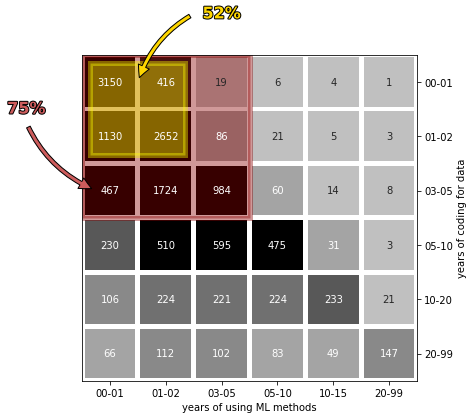

In [8]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

this_ax = ax
draw_code_ml_heatmap(this_ax);
draw_border_around_axes(this_ax)

_, an1 = box_with_annot(0,0,3,3,"","darkred",this_ax)
annotxt = "{0:.0f}%"\
    .format(np.round(allage_codepivot2.iloc[0:3,0:3].sum().sum()/all_participants, 2)*100)
annot_with_arrow(annotxt, "indianred", this_ax, (-1,1),  (-1, 1.25), (0.25,2.5))

_, an2 = box_with_annot(0.15,0.15,1.7,1.7,"","yellow",this_ax)
annotxt = "{0:.0f}%"\
    .format(np.round(allage_codepivot2.iloc[0:2,0:2].sum().sum()/all_participants, 2)*100)
annot_with_arrow(annotxt, "gold", this_ax, (2.5,-0.75),  (2,-0.75), (1,0.5))

this_ax.yaxis.tick_right()
this_ax.yaxis.set_label_position("right")




There are other features catching our attention here. Let's look at what happens on the diagonal, and off the diagonal. Basing on this criterium, we can split the population of Kagglers into three big groups: 
- Kagglers who have been coding to analyze data for longer than they have been using machine learning (<span style="background:limegreen; font-weight:bold; color:white">code-first</span>)
- Kagglers who have been in machine learning for longer than they have been coding for data (<span style="background:mediumorchid; font-weight:bold; color:white">ML-first</span>)
- Kagglers who have similar experience in both coding and machine learning, therefore the two aspects have been likely highly intercorrelated for them (<span style='background:BlanchedAlmond; font-weight:bold;'>code and ML interrelated</span>)

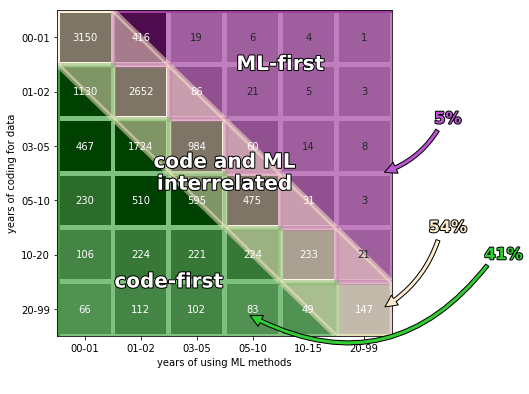

In [9]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()
draw_code_ml_heatmap(ax);
draw_border_around_axes(ax)

l_ml = []
j = 0
for i in np.arange(1,8):
    l_ml.append([i,j])
    j+=1
    l_ml.append([i,j])
l_ml = l_ml[:-1]
l_ml.append([i,0])
ax.add_patch(Polygon(l_ml, color="purple", lw=5, fill=True, alpha=0.5))
an1 = ax.annotate("ML-first", xy=(4, 1), fontsize=20, color="white", weight='bold',
           verticalalignment='center', horizontalalignment='center');
black_border_around_text(an1);

annotxt = "{0:.0f}%"\
    .format(np.round(ml_first.shape[0]/all_participants, 2)*100)
annot_with_arrow(annotxt, "mediumorchid", ax, (7,2),  (6.85,2.15), (5.8,3), conn_style="arc3,rad=-0.2")


l_c = []
i = 0
for j in np.arange(1,8):
    l_c.append([i,j])
    i+=1
    l_c.append([i,j])
l_c = l_c[:-1]
l_c.append([0,j])
ax.add_patch(Polygon(l_c, color="green", lw=5, fill=True, alpha=0.5))
an2 = ax.annotate("code-first", xy=(2, 5), fontsize=20, color="white", weight='bold',
           verticalalignment='center', horizontalalignment='center');
black_border_around_text(an2);

annotxt = "{0:.0f}%"\
    .format(np.round(code_first.shape[0]/all_participants, 2)*100)
annot_with_arrow(annotxt, "limegreen", ax, (8,4.5),  (7.85,4.5), (3.25,5.5), conn_style="arc3,rad=-0.45")




ax.add_patch(Polygon([[0,0], [1,0], [6,5], [6,6], [5,6], [0,1]],
                     color="blanchedalmond", lw=5, fill=True, alpha=0.5))
an3 = ax.annotate("code and ML\ninterrelated", xy=(3, 3), fontsize=20, color="white", weight='bold',
           verticalalignment='center', horizontalalignment='center', rotation=0);
black_border_around_text(an3);

annotxt = "{0:.0f}%"\
    .format(np.round(interrelated.shape[0]/all_participants, 2)*100)
annot_with_arrow(annotxt, "blanchedalmond", ax, (7,4),  (6.85,4.15), (5.8,5.5), conn_style="arc3,rad=-0.2");



Because the categories were not identical for both of the questions, and because of the fuzzy nature of the boundaries (*If I started with machine learning in 2017, have I been doing it 1-2 years, or 2-3 years?*), the off-diagonal entries that are very close to the diagonal should be intepreted also with a doze of fuzziness and uncertainty. But it doesn't change the fact that 5 Kagglers said that they have been using machine learning for more than 10 years while having coded for less than a year! (were they using visual or point-and-click tools? or proving theorems on paper? or made a mistake in the answer? or just trolling?)

We can also name some simple subgroups here, which will help us better interpret the survey results later on. I will focus on the "prototypical" groups, on the extreme sides. 

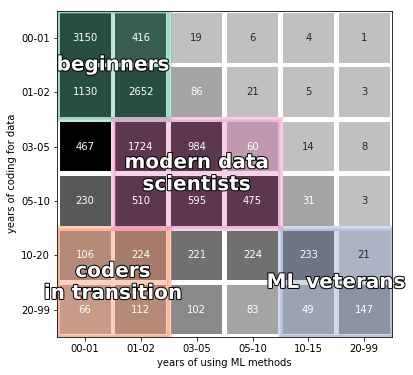

In [10]:

f = plt.figure(figsize=(6,6))
ax = plt.axes()
draw_code_ml_heatmap(ax);
draw_border_around_axes(ax)

cls = list_colors("Set2", 8)

_, an1 = box_with_annot(0,0,2,2,"beginners",cls[0],ax)
black_border_around_text(an1);

_, an2 = box_with_annot(0,4,2,2,"coders\nin transition",cls[1],ax)
black_border_around_text(an2);

_, an3 = box_with_annot(4,4,2,2,"ML veterans",cls[2],ax)
black_border_around_text(an3);

_, an4 = box_with_annot(1,2,3,2,"modern data\nscientists",cls[3],ax)
black_border_around_text(an4);


# print([mcolors.rgb2hex(x) for x in cls])

The first group are the <span style="background:#66c2a5; font-weight:bold; color:white">beginners</span>. They have less than 2 years of experience of both coding and ML methods, and so they likely have started with the topic around 2017 the earliest. As I mentioned before, they make up for around 50% of all survey participants. 

The second group are <span style="background:#fc8d62; font-weight:bold; color:white">coders in transition</span>. Those people have a decades-long coding experience for working with data, however they have started working with machine learning only recently. These may be for example software engineers transitioning into data engineers. 

The third group belongs in the lower right corner and these are the <span style="background:#8da0cb; font-weight:bold; color:white">machine learning veterans</span>. Those people have been coding since long before the current AI revolution - with 10 or even over 20 years of both ML and coding experience, they may have started to specialize in the topic around 2000s or even late 1990s. These people were doing machine learning before it was cool. They likely know methods that are rare to find in the current data science curriculum, as well as have deep understanding of modern methods. 

The last group to point out is the group in the middle: <span style="background:#e78ac3; font-weight:bold; color:white">modern data scientists</span>. They have started to be interested in the topic more less around 2015, so at the beginning of the boom, when ML started to go public. They are the most likely to have some kind of a "standard" education in the modern state-of-the-art tools, both for coding and machine learning. They have or are about to have passed the initial learning phase and can provide measurable value. 

Now that we made friends with the heatmap as it is, let's use it as a tool to understand better the survey results. 

## Chapter 2: how to use the heatmap as a tool to generate further insights

This heatmap in general informs us about the distribution of a specific population of survey takers when it comes to their experience in coding and machine learning. What we drew above corresponds to the total number of survey takers. Instead of using absolute number of counts in each bin, we can normalize it to get percentage of given population falling into each bin. We can then use it as a reference - we can calculate such a code-ML heatmap for a given subgroup of survey responders, and compare the two distributions to better understand the differences between that subgroup and general population. 

For clarity, I leave out the axes descriptions for now, and adjust the color scale to better represent the data. 

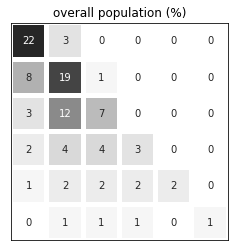

In [11]:
this_ax = plt.axes()
rh = refhist
heatmap_args_ref2 = heatmap_args_ref.copy()
heatmap_args_ref2['annot_kws'] = {"size":10}
draw_mini_heatmap(
        round((rh)*100), 
        this_ax, "overall population (%)", **heatmap_args_ref2);

We can now compare this for example with the two heatmaps corresponding to the subpopulation of Kagglers, who defined themselves as "Students" and "Data Scientists" in Question 5 respectively.

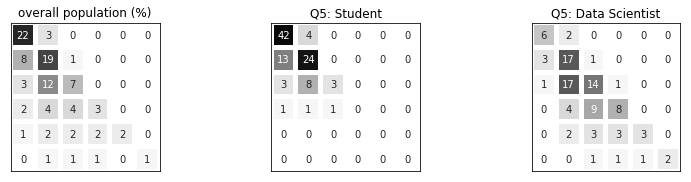

In [12]:

f, ax = plt.subplots(ncols=3, nrows=1, figsize = (12,4),
                     gridspec_kw = {"wspace":0.75})

this_ax = ax[0]
draw_mini_heatmap(
        round((refhist)*100), 
        this_ax, "overall population (%)", **heatmap_args_ref2)

for i, job_name in enumerate(['Student', "Data Scientist"]):
    st = calc_df_hist(create_pivot_for_heatmap(multiple.query('Q5 == @job_name')))
    this_ax = ax[i+1]
    draw_mini_heatmap(
            round((st)*100), 
            this_ax, "Q5: "+job_name, **heatmap_args_ref2)

Comparing the three heatmaps as they are already brings some insights. 
- Among the group of students, 42% has less than a year experience in coding and using machine learning, while among the group of data scientists only 6% of people belong to this bin. 
- We also see that 2% of data scientists belongs to the group of the extreme veterans (>20 years of experience), while in general population only 1% belongs to this bin. 
- Among data scientists, the majority (almost 50% in total) is concentrated in the middle part of the heatmap, and there is a disproportionally bigger proportion of people especially in groups that use coding for 3-10 years and machine learning for 2-5 years. 

However, going through each survey response like this would be extremely tiring, so I developed another way of visualizing these differences: 
1. I subtract the reference histogram (depending on a question, it will be either overall population of survey takers, or for example the ones that declared themselves as non-students - following the survey schema). 
2. Because I mostly want qualitative insights, I leave out the numbers and encode values in the difference histogram as colors. 

Let's look at an illustrative example: 

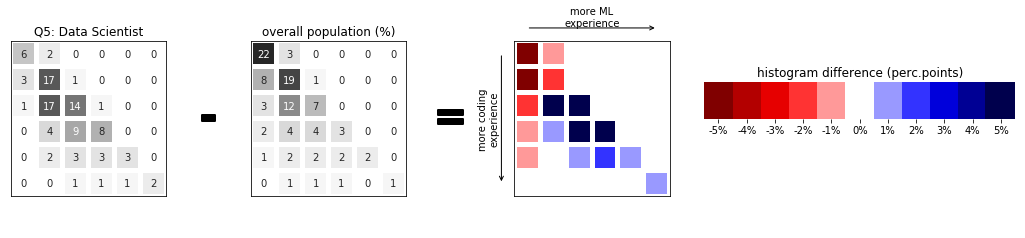

In [13]:

f, ax = plt.subplots(ncols=6, nrows=1, figsize = (18,4),
                     gridspec_kw = {"width_ratios":[1,0.1,1,0.25,1,2],"wspace":0.25})

job_name = "Data Scientist"

this_ax = ax[0]
st = calc_df_hist(create_pivot_for_heatmap(multiple.query('Q5 == @job_name')))
draw_mini_heatmap(
        round((st)*100), 
        this_ax, "Q5: "+job_name, **heatmap_args_ref2)

this_ax = ax[1]
an1 = this_ax.annotate("-", xy=(0.5,0.5), fontsize=40, color="black", weight='bold',
               verticalalignment='center', horizontalalignment='center', annotation_clip=False)
black_border_around_text(an1);
hide_axes(this_ax)

this_ax = ax[2]
draw_mini_heatmap(
        round((rh)*100), 
        this_ax, "overall population (%)", **heatmap_args_ref2)

this_ax = ax[3]
an1 = this_ax.annotate("=", xy=(0.25,0.5), fontsize=40, color="black", weight='bold',
               verticalalignment='center', horizontalalignment='center', annotation_clip=False)
black_border_around_text(an1);
hide_axes(this_ax)


# this_ax = ax[2]
# draw_mini_heatmap(
#         (st - rh), 
#         this_ax, "difference histogram", **heatmap_args_nolim_sq)


draw_zero_heatmap_legend(ax[4], ax[5], (st-rh));

By reducing the complexity of the data representation and encoding the matrix numbers as an easily interpretable colored pattern, we can gather insights much quicker and with less cognitive load. Here for example we immediately see that the Kagglers who describe as data scientists have on average much <span style="background:#3333ff; font-weight:bold; color:white">more ML and coding experience than the overall population</span>, and there is <span style="background:#ff3333; font-weight:bold; color:white">relatively less people only starting to code</span> in this group. A remark: white cells signify no big difference between the selected group and general population - and not necessarily that there is no counts in this cell! 

## Chapter 3: insights from the survey

We can now use this way of visually encoding the data to draw some insights from the survey. I designed a little dashboard to visualize answers to each analyzed survey question - in the top row, there is a guide on how to read the plots, colorbar for the difference histograms, relevant reference histogram with the absolute numbers, and a simple bar plot to give some feeling about the number of respondents per each answer (oh, those bar plots). 

Since there is already so many great kernels focusing on the nationality, gender and age of the survey participants, I am going to concentrate more on the work-related questions. I am going to visualize the answers to selected questions, grouped by the topics, and comment them briefly below. 

### Job title and education

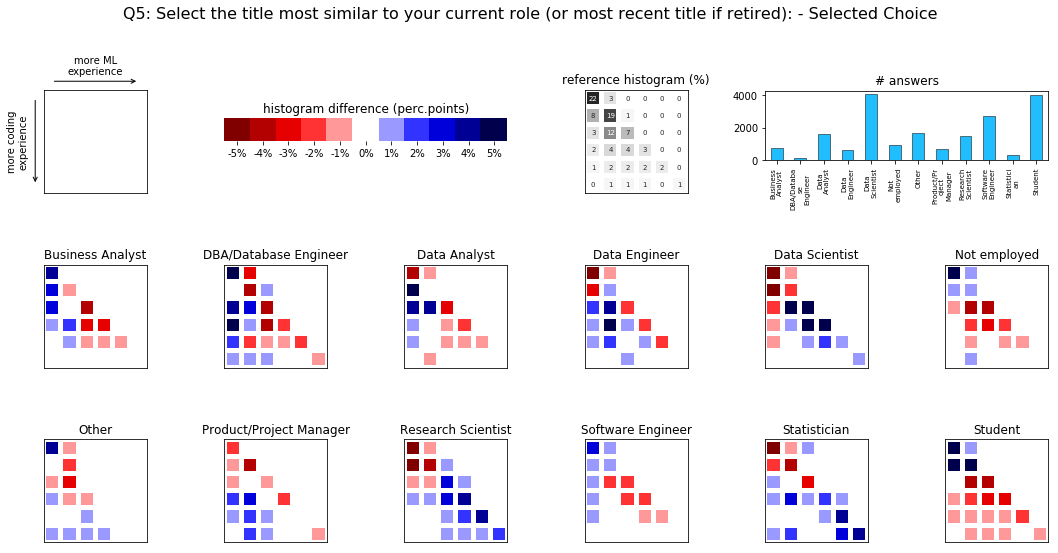

In [14]:
# For the single-choice questions 

col = "Q5"
values_list = get_unique_vals_naive(col)
dashboard_single_choice(col, values_list, refhist)



Here an interesting pattern emerges: 
- **Business Analysts**, **Data Analysts**, **Software Engineers** tend to have experience in coding (across all the age categories), and overall little experience in ML
- **Students** and **Not employed** are mostly beginners 
- **DBA/DB Engineers** have similar profile to **Data Engineers**, with longer coding experience than ML experience, and surprisingly for me, more ML experience than the Analysts 
- **Project Managers** are predominantly in the corner corresponding to transitioning experienced coders. I was surprised to see that so many have quite some ML experience
- **Data Scientists** are mostly in the middle: 2-10 years of experience in both coding and ML 
- **Research Scientists** and **Statisticians** tend to be focused in the ML veterans corner - although some Statisticians also do a lot of coding and little ML! 

One interesting thing is to compare the profile of Data Scientists, Research Scientists and Statisticians. On one hand the differences may reflect the proverb that "Data Scientist" is just a more sexy name for a "Statistician", invented recently - that's why Data Scientists have less experience in comparison, because the name is just newer. On the other hand, the difference between Data Scientists and Research Scientists may be reflecting the historical reasons, but it may be also the application-oriented role of a Data Scientist. Namely, you don't need people with 20 years of ML experience to build a deployable recommender system. 


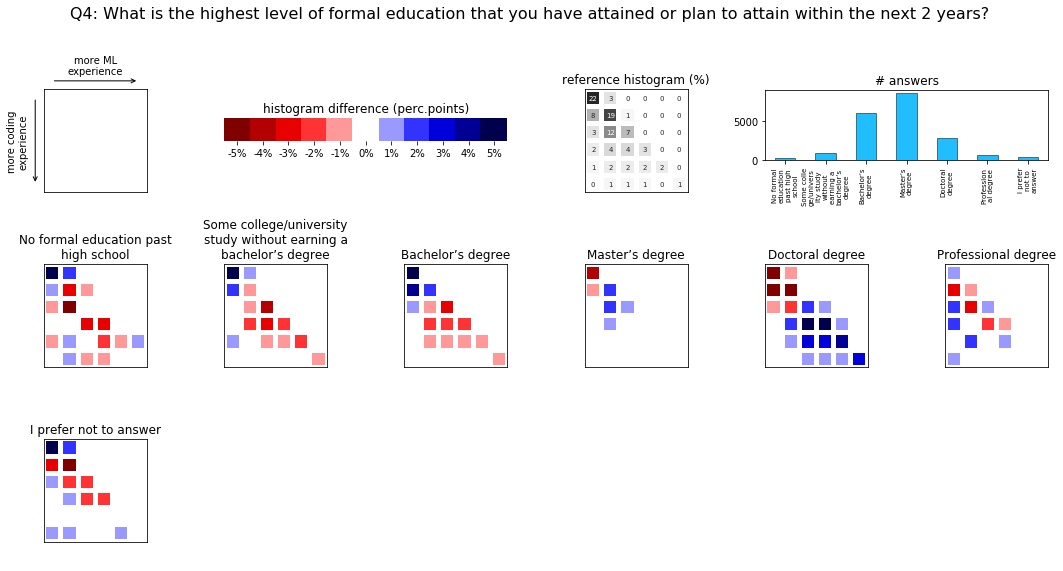

In [15]:
# For the single-choice questions 

col = "Q4"
values_list = get_unique_vals_naive(col)
values_list = values_list[[4,6,0,3,1,5,2]]
dashboard_single_choice(col, values_list, refhist)


Here the pattern is clear and not so surprising, almost disappointingly. 
- The higher your academic title, the more coding and ML experience your peer group has. 
- The patterns of "I prefer not to answer" and "No formal education" are interesting, but not so insightful given relatively small number of survey takers in those categories. 
- I wonder how these distributions would look like in a few years from now - will the people with Bachelor's degree who don't pursue the Master's or PhD, advance in their ML-experience, or will they get stuck in non-ML related activities? Will the formal education turn out important in the long run, now that there is so many great ways to learn data science outside of the academic environment? 

### Work environment

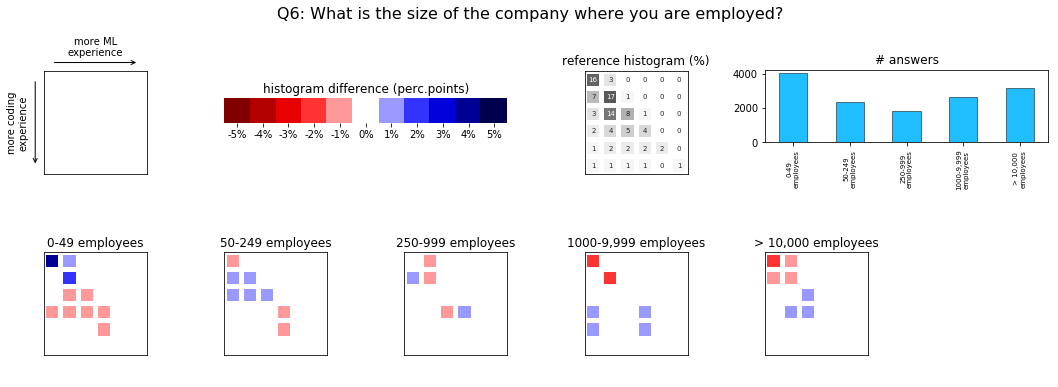

In [16]:
# For the single-choice questions 

col = "Q6"
values_list = get_unique_vals_sorted(col)
rh = refhist_nostudents_nounempl

dashboard_single_choice(col, values_list, rh)


- It looks like the size of the company doesn't matter that much when it comes to attracting the type of talent. This is somewhat contradictory to my intuitions: I would expect very small companies (startups?) and the biggest companies (the richest ones) to attract the most experienced data scientists. But this is not visible - at least not at this level of granularity. 
- There is a strong tendency however for little companies to have more beginners, and slight tendency for the biggest companies to have less beginners and more specialists, but overall the distributions seem pretty similar to the overall population. 

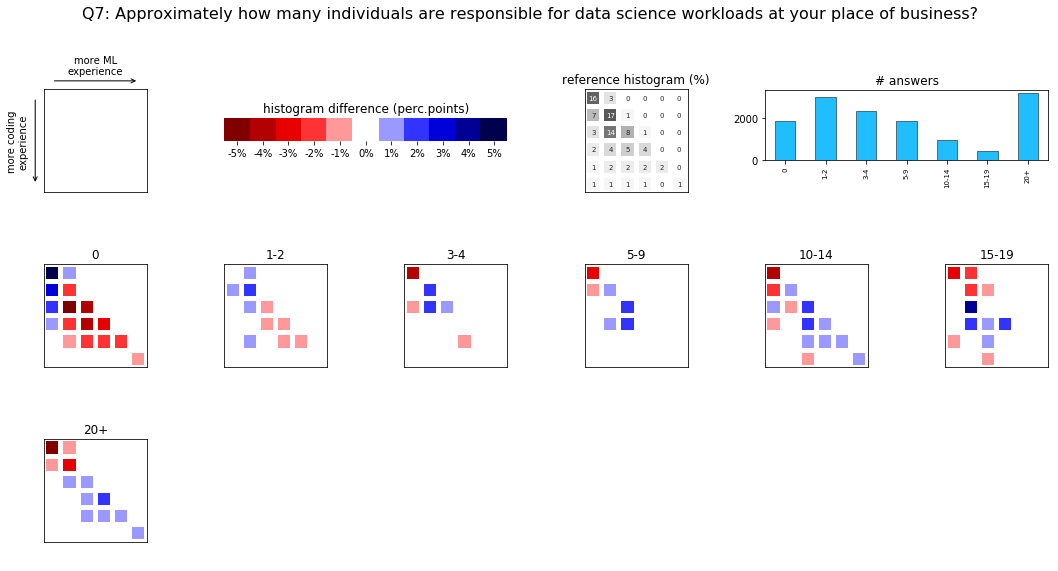

In [17]:
# For the single-choice questions 

col = "Q7"
values_list = get_unique_vals_sorted(col)
rh = refhist_nostudents_nounempl

dashboard_single_choice(col, values_list, rh)


- It is really great to see a big bunch of enthusiasts here - people working in places where there is no established data science workload at all, who have moderate to advanced coding experience, using Kaggle as their hobby and passion! 
- It is a pity however that there are very few experienced ML-hobbysts who keep on working for businesses with no official data science teams. Somehow I was hoping to see here this romantic image of a "postman during the day, ML-practicioner during the night". But maybe all the postmen who learn ML good enough just move on to companies that actually appreciate ML, so that they can cash in their ML-amplified salary too? 
- It seems that if you want to learn from and work with the veterans, you need to look for a workplace with a data science team size of more than 10 people. 
- If you prefer to work in a smaller team, you will be likely surrounded by people with moderate coding and ML experience (the advantage being though that you have more influence on how the data science is being done in your company)
- It is fascinating to see that so many Kagglers work in the teams consisting of 20+ people! But what if all of them just work in the same biggest 4 companies employing thousands of data scientists?... 

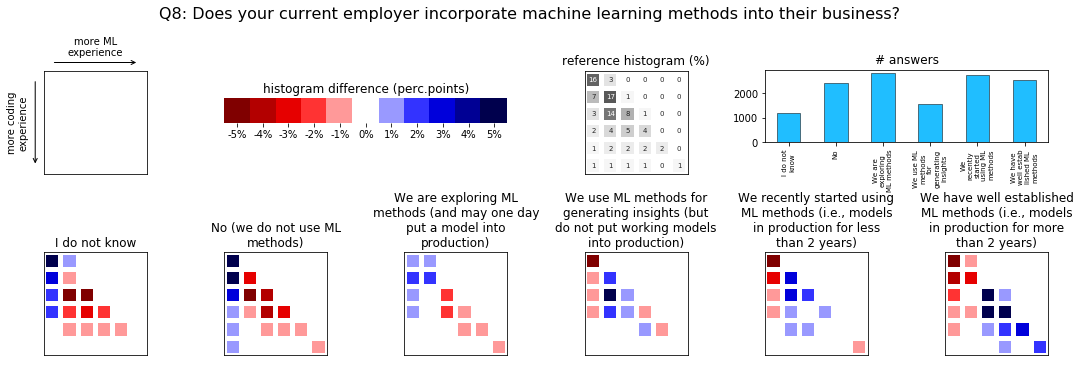

In [18]:
# For the single-choice questions 

col = "Q8"
values_list = get_unique_vals_naive(col)
values_list = values_list[[0,1,2,5,4,3]]
rh = refhist_nostudents_nounempl

dashboard_single_choice(col, values_list, rh)


Really clear correlation between the data-scientific maturity of the employer and the experience of the employees. 
- People who work for companies where the workflow is established are generally a very experienced crowd 
- The fresh ML-hobbysts come here very clearly again: among the people, whose employer doesn't do data science work, most of them are the ML-beginners, with less than a year of ML experience. 
- In companies, where ML is used for generating insights or in production for less than 2 years, many people have 1-5 years of ML experience. This means that maybe many of them actually gained their experience while implementing ML workflows in their place of work
- Last but not least, great to see that so many employers already implement machine learning in their business! Survey takers working in companies where: 1. there is no or little ML workflow, 2. there is an active exploration or prototyping going on, 3. there is a productive environment for ML, are in a quite balanced mix overall. 

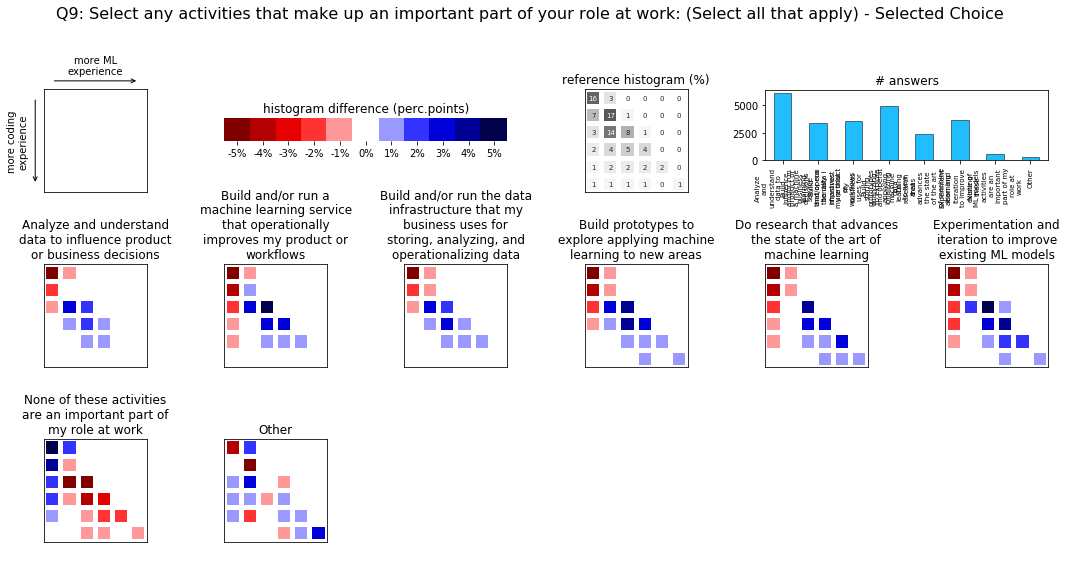

In [19]:
# For the multiple-choice questions 

col = "Q9"
rh = refhist_nostudents_nounempl

dashboard_multi_choice(col, rh)


Here again the data supports the common-sense understanding of the tasks and skills available on the market, and their matching. 
- People who are already proficient in coding/ML, but are not the experts, tend to gather in the tasks relating to **business decisions, infrastructure and product improvements** 
- Tasks relating to **experimentation and research** are covered more by the people reaching into the ML veteran area 
- The real goldmine is the category of **Other**, which is covered by a lot of people from the off-diagonal, mostly experienced coders with little or some ML experience. Quick look into the free text responses suggest a whole multitude of tasks. This paints a much more colorful picture of the job-related activities bringing people to become fascinated in ML/data science - or the many AI-related tasks available already to employees with little ML-experience. It would be a really interesting project to look at this deeper! Some of the tasks include:  
    - consultation and education 
    - BI, data visualization, dashboards 
    - design 
    - analytics without ML
    - sales, marketing 
    - data democratization
    - stakeholder management 
    
    

### Toolkit

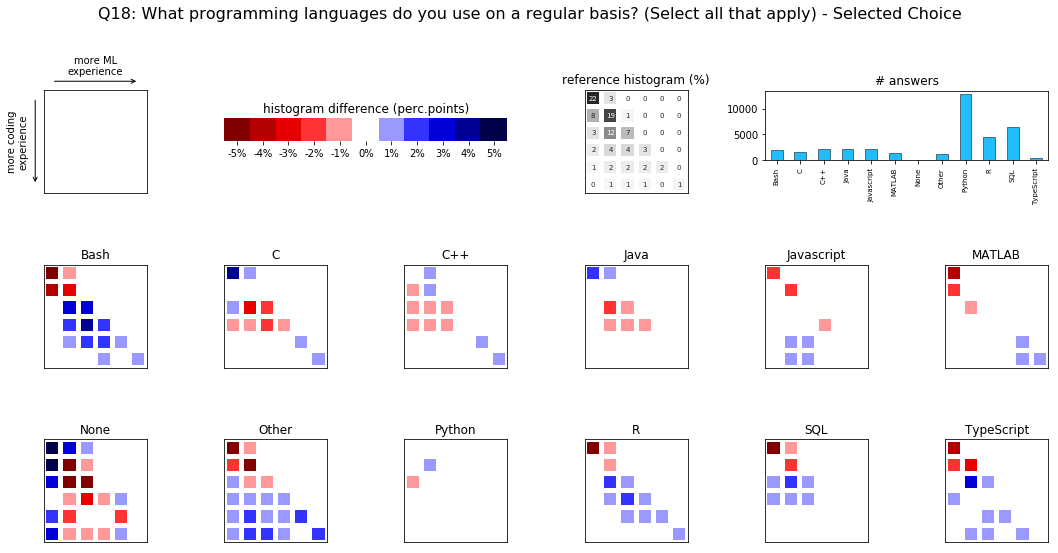

In [20]:
# For the multiple-choice questions 

col = "Q18"
rh = refhist

dashboard_multi_choice(col, rh)


- Pretty much everybody uses **Python** across all the experience levels, yay!
- Quite a lot of people use **SQL** and **R**, but rarely the beginners. This makes the initiative of Kaggle to make an SQL course a really valuable one! The SQL seems to be more preferred by the coders transitioning to ML, while R is being used more by the people for whom coding and ML are interrelated
- Oh, hello there, **Bash**! Almost no beginners there, and a lot of people with considerable experience. 
- **C** and **Java**: really interesting to see that there is such a spike in the group of the absolute beginners. What is the reason for this? Are these languages taught in school? Or are these people willing to generally enter "programming" and this is what they first reach for? 
- **Javascript** has a bigger proportion of the coders in transition - maybe these are the web developers exposed and fascinated by the AI products? 
- **MATLAB** has some representation of ML veterans. I would guess that in this case it points to their academic background or academic-flavor of the tasks they are doing, since it is uncommon to use it in production and at scale

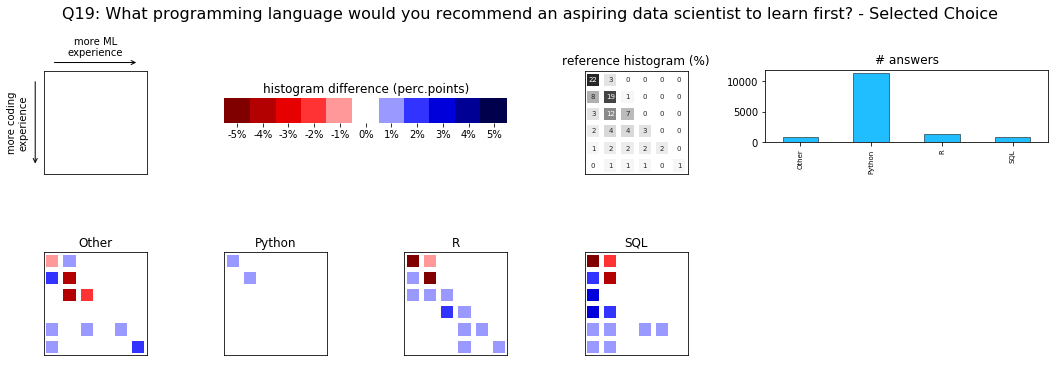

In [21]:
# For the single-choice questions 

col = "Q19_clean"
values_list = get_unique_vals_naive(col)
rh = refhist

dashboard_single_choice(col, values_list, rh)



- Also, similarly to how everyone uses Python, almost everybody recommends **Python** as the first language to learn
- Interestingly, **SQL** is more preferred by the coders and coders in transition, while recommendations for **R** have a large share of ML-specialists and veterans. This makes a lot of sense: both groups use these tools respectively, and therefore see a lot of benefit from knowing them! 
- The distinction between SQL and R also points to the duality of the tasks that the data scientists have to perform - one is more on the research and statistics side, while the other more on the pragmatic and production side. It would be really cool to follow this distinction more in-depth in a branch-out analysis 

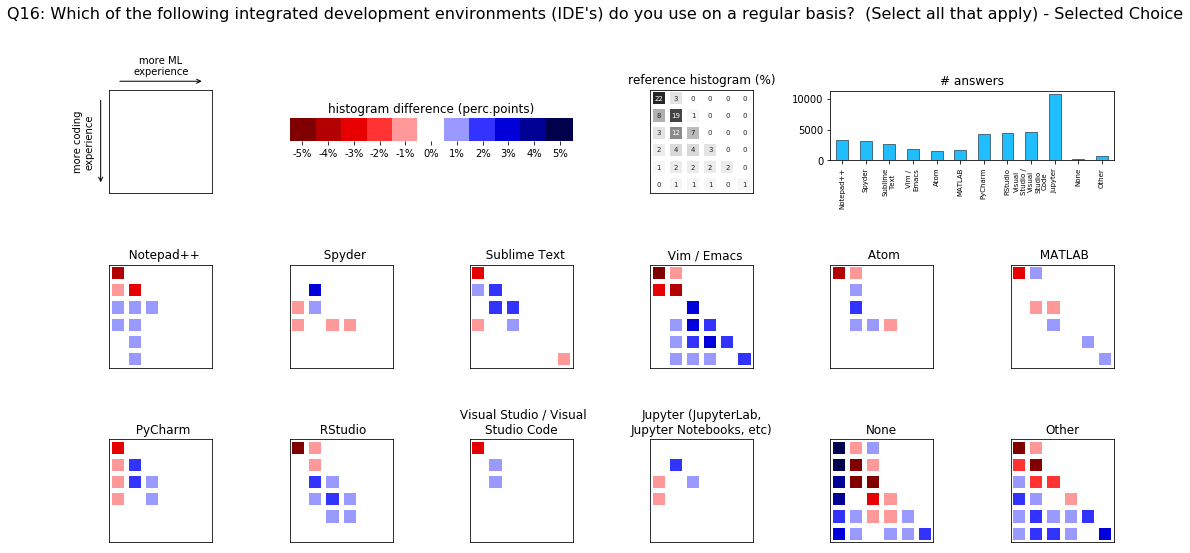

In [22]:
col = "Q16"
rh = refhist

dashboard_multi_choice(col, rh)

- Great to see that almost everybody uses **Jupyter** (although some more development-focused people would probably disagree with me that it is indeed so "great"). Relatively similar pattern comes up for **Visual Studio Code** and **Spyder** 
- **Notepad++** has quite a systematic popularity among coders who are not so much into ML yet 
- **Pycharm**, **Atom** and **Sublime Text** tend to be particularly popular among people who already have some - but not a lot - ML and coding experience 
- **RStudio** is very consistent with R usage, not surprisingly
- Oh, hello there, **Vim and Emacs**! Is this the same club that uses Bash? 

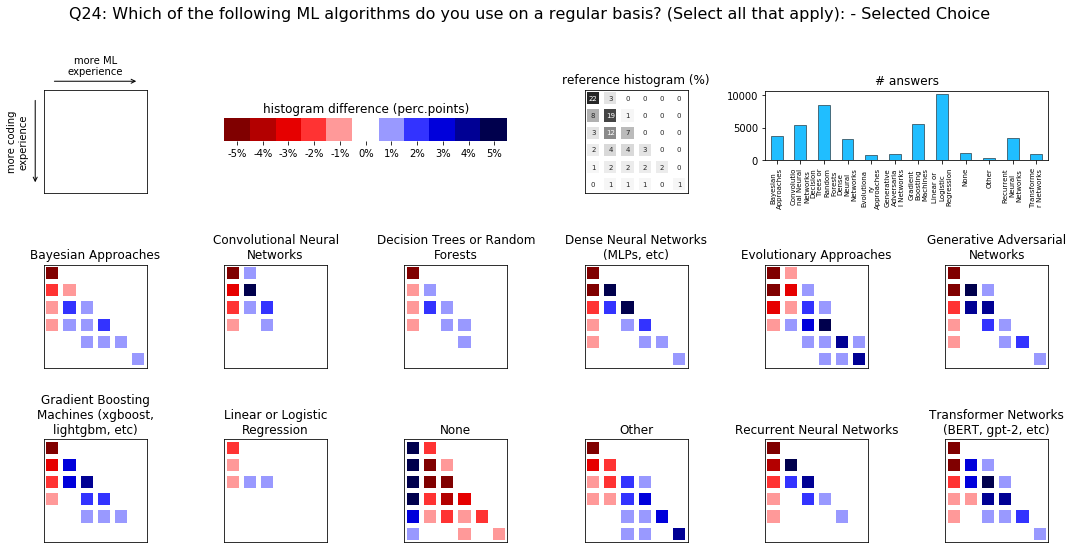

In [23]:
# For the multiple-choice questions 

col = "Q24"
rh = refhist

dashboard_multi_choice(col, rh)



- Almost everybody uses **Linear or Logistic Regression**! We just cannot live without it, can we 
- There seems to be an algorithm progression (or pecking order, if you like), basing on the increasing experience of populations that use it: 
    1. Regression 
    - CNNs; Trees and Forests
    - Gradient Boosting; RNNs; Bayesian Approaches 
    - Dense Neural Networks; GANs; Transformer Networks
    - Evolutionary Approaches
- **Other**: now this is interesting! What do the experienced people use, which is not listed here? Pity that we cannot simply correlate the free text responses with the other variables relating to the particular survey participant. But a quick peek gives a glimpse: 
    - SVMs
    - LSTMs
    - clustering 
    - time series
    - ensembles 
    - autoencoders
    - fuzzy reasoning 
    - proprietary algorithms
    - and finally, my favorite answer: *pain and motivation*

### Online data science community

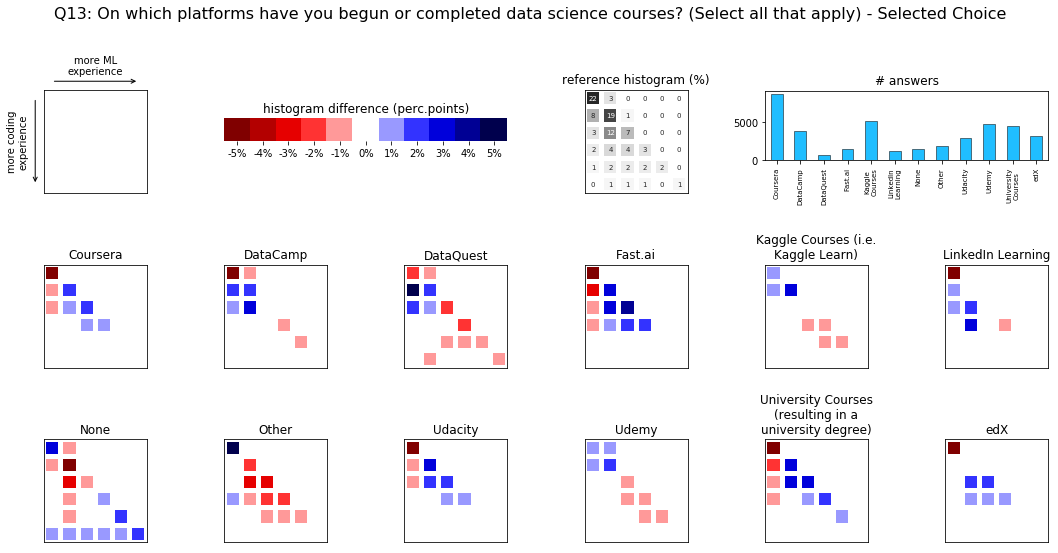

In [24]:
col = "Q13"
rh = refhist

dashboard_multi_choice(col, rh)

- People using **Kaggle Courses** and **Udemy** tend to start their ML and coding adventure 
- Among **DataCamp**, **DataQuest**, **Linkedin Learning** communities there are particularly many code-first people with intermediate coding skills and some ML skills 
- **Coursera**, **Fast.ai**, **Udacity**, **edX** - and **University Courses** - tend to attract people for whom coding and ML is interrelated and who are no longer beginners 
- The people who **do not do any courses** are mostly those with more than 20 years experience in coding, no matter their ML experience. Maybe after reaching some age you really don't feel like it anymore. It would be really interesting to find out if they stay up to date nevertheless! 

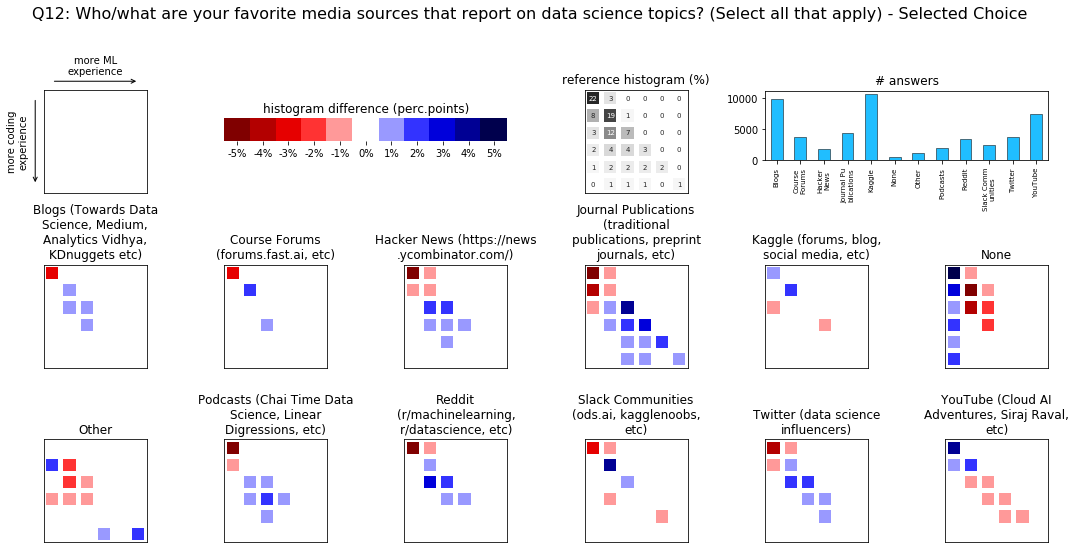

In [25]:
col = "Q12"
rh = refhist

dashboard_multi_choice(col, rh)

- Here the most profound difference is between the **Youtube** and the **Journal Publications (Paper)** communities. 
- The **Youtube** community comprises from many beginners, as YT is a great resource to quickly gain knowledge and a broad and shallow understanding of many concepts. 
- **Paper** community is on the other side of the spectrum: a lot of people here come from the pool of experienced data scientists and the ML veterans. 
- People who use **podcasts**, **Twitter** and **Reddit** tend to be intermediate experienced data scientists
- People who **don't use ML-related media sources** tend to have very little ML experience. But wait just a year more until they get hooked! 
- Everybody loves **Blogs**, **Course Forums** - and **Kaggle**, of course! 

## Wrap up

This is the end of a long journey. We made friends with one heatmap, looked at it in detail, and then used it as a tool to learn something more about the survey. I hope you had an interesting time reading about my work and my insights! I also hope to have inspired you to search for other creative ways to use known data visualizations in order to look at your dataset in a new way. 

Thanks a lot to the other participants of the competition for their insights, and of course thanks to the Kaggle team for letting us play with this great dataset! 